# EXERCISE 1: BERT FINE-TUNING FOR SENTIMENT CLASSIFICATION
Text Classification with Pre-trained Transformers and Fine-tuning Strategies

In [ ]:
# !pip uninstall -y numpy scipy gensim transformers
# !pip install numpy==1.21.6
# !pip install scipy==1.9.3
# !pip install gensim==4.3.2
# !pip install transformers==4.21.3
# !pip install datasets peft evaluate seqeval

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
Found existing installation: transformers 4.52.4
Uninstalling transformers-4.52.4:
  Successfully uninstalled transformers-4.52.4
ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement numpy==1.21.6 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 1.13.3, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0, 1.15.1, 1.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 11.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 14.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (tokenizers)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from huggingface_hub import login
login("YOUR_HF_TOKEN_HERE")

## Environment Setup & Libraries
Setting up required libraries and checking GPU availability.

In [ ]:
# Core libraries
import os
import io
import string
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Utility data structures
from collections import defaultdict, Counter

# Natural Language Processing (NLP)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer  # Keep for baseline

# Data preprocessing & evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, precision_recall_curve, auc
)

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# BERT and Transformers - FIXED IMPORTS
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW  # AdamW is now in PyTorch, not transformers

from sklearn.metrics import precision_recall_fscore_support, classification_report

# Downloading data from the web
import requests
import gzip

from IPython.display import clear_output

In [ ]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

clear_output()

In [ ]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Dataset Loading & Preprocessing
### IMDB Movie Reviews Dataset
Loading the IMDB dataset for binary sentiment classification (50K reviews) - now adapted for BERT fine-tuning.

In [ ]:
def download_movie_reviews_dataset():
    print("Downloading IMDB Large Movie Review Dataset...")
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    response = requests.get(url, stream=True)
    compressed_file = io.BytesIO(response.content)

    with gzip.open(compressed_file, 'rb') as f_in:
        with open('aclImdb_v1.tar', 'wb') as f_out:
            f_out.write(f_in.read())

    import tarfile
    with tarfile.open('aclImdb_v1.tar', 'r') as tar:
        tar.extractall()
    os.remove('aclImdb_v1.tar')

    def load_reviews(directory, label):
        reviews = []
        for filename in os.listdir(directory):
            if filename.endswith('.txt'):
                with open(os.path.join(directory, filename), 'r', encoding='utf-8') as f:
                    reviews.append((f.read(), label))
        return reviews

    positive_train = load_reviews('aclImdb/train/pos', 'positive')
    negative_train = load_reviews('aclImdb/train/neg', 'negative')
    positive_test = load_reviews('aclImdb/test/pos', 'positive')
    negative_test = load_reviews('aclImdb/test/neg', 'negative')

    all_data = positive_train + negative_train + positive_test + negative_test
    df = pd.DataFrame(all_data, columns=['text', 'sentiment'])
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"Dataset loaded! Total samples: {len(df)}")
    return df

# Load dataset
df = download_movie_reviews_dataset()

Dataset loaded! Total samples: 50000


### Data Splitting and Statistics
Splitting into train/test sets and analyzing dataset characteristics.

In [ ]:
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42, stratify=df['sentiment'])

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 35000
Test set size: 15000


In [ ]:
def tokenize(data):
    stop_words = stopwords.words('english')
    stop_words.extend(string.punctuation)
    stop_words.extend(["the", "of", "and", "as", "a", "to", "in", "on", "for"])
    tokenized_samples = []
    for sample in data:
        tokens = []
        sentences = sent_tokenize(sample)
        for sent in sentences:
            words = word_tokenize(sent)
            for word in words:
                if '\n' in word or "\t" in word or "--" in word or "*" in word or "@" in word or "#" in word or word.lower() in stop_words:
                    continue
                if word.strip():
                    tokens.append(word.replace('"', "'").strip().lower())
        tokenized_samples.append(tokens)
    return tokenized_samples

### Text Preprocessing Pipeline
- Raw text processing for BERT tokenizer compatibility
- Preserving original text structure for transformer input
- Label encoding for classification head

## Baseline Classifier Implementation
Simple word-sentiment mapping baseline using TF-IDF features for comparison.

In [ ]:
# Baseline classifier implementation for comparison
class BaselineSentimentClassifier:
    def __init__(self):
        self.word_to_sentiment = {}
        self.most_common_sentiment = None
        self.feature_names = None

    def train(self, X_train, y_train, feature_names=None):
        self.feature_names = feature_names
        sentiment_counts = Counter(y_train)
        self.most_common_sentiment = sentiment_counts.most_common(1)[0][0]

        if self.feature_names is not None:
            for i, feature in enumerate(self.feature_names):
                feature_col = X_train[:, i].toarray().flatten() if hasattr(X_train, 'toarray') else X_train[:, i]
                sentiment_counts = defaultdict(int)
                for sample_idx, value in enumerate(feature_col):
                    if value > 0:
                        sentiment_counts[y_train[sample_idx]] += 1
                if sentiment_counts:
                    self.word_to_sentiment[feature] = max(sentiment_counts.items(), key=lambda x: x[1])[0]

    def predict(self, X_test):
        predictions = []
        if self.feature_names is None:
            return np.full(X_test.shape[0], self.most_common_sentiment)

        for i in range(X_test.shape[0]):
            sample = X_test[i].toarray().flatten() if hasattr(X_test, 'toarray') else X_test[i]
            sample_sentiments = []
            for feature_idx, value in enumerate(sample):
                if value > 0 and self.feature_names[feature_idx] in self.word_to_sentiment:
                    sample_sentiments.append(self.word_to_sentiment[self.feature_names[feature_idx]])

            if sample_sentiments:
                predictions.append(Counter(sample_sentiments).most_common(1)[0][0])
            else:
                predictions.append(self.most_common_sentiment)
        return np.array(predictions)

    def predict_proba(self, X_test):
        predictions = self.predict(X_test)
        n_classes = len(np.unique(predictions))
        probs = np.zeros((X_test.shape[0], n_classes))
        for i, pred in enumerate(predictions):
            probs[i, pred] = 1.0
        return probs

In [ ]:
# Simple preprocessing for baseline
def preprocess_for_baseline(train_data, test_data):
    X_train, X_val, y_train, y_val = train_test_split(
        train_data['text'], train_data['sentiment'], test_size=0.3, random_state=42)
    X_test, y_test = test_data['text'], test_data['sentiment']

    unique_labels = pd.concat([y_train, y_val, y_test]).unique()
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

    y_train = np.array([label_to_idx[label] for label in y_train], dtype=np.int64)
    y_val = np.array([label_to_idx[label] for label in y_val], dtype=np.int64)
    y_test = np.array([label_to_idx[label] for label in y_test], dtype=np.int64)

    X_train_tokenized = tokenize(X_train)
    X_val_tokenized = tokenize(X_val)
    X_test_tokenized = tokenize(X_test)

    X_train_joined = [" ".join(x) for x in X_train_tokenized]
    X_val_joined = [" ".join(x) for x in X_val_tokenized]
    X_test_joined = [" ".join(x) for x in X_test_tokenized]

    vectorizer = TfidfVectorizer(max_features=2000, sublinear_tf=True)
    X_train = vectorizer.fit_transform(X_train_joined).toarray()
    X_val = vectorizer.transform(X_val_joined).toarray()
    X_test = vectorizer.transform(X_test_joined).toarray()
    feature_names = vectorizer.get_feature_names_out()

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), feature_names, label_to_idx

In [ ]:
# Train baseline classifier
print("\n--- Training Baseline Classifier ---")
(X_train_base, y_train_base), (X_val_base, y_val_base), (X_test_base, y_test_base), feature_names, label_to_idx_base = preprocess_for_baseline(train_data, test_data)

baseline_model = BaselineSentimentClassifier()
baseline_model.train(X_train_base, y_train_base, feature_names)

# Evaluate baseline
test_preds_baseline = baseline_model.predict(X_test_base)
baseline_accuracy = accuracy_score(y_test_base, test_preds_baseline)
baseline_f1 = f1_score(y_test_base, test_preds_baseline, average='weighted')

print("=== BASELINE MODEL RESULTS ===")
print(f"Test Accuracy: {baseline_accuracy:.4f}")
print(f"Test F1: {baseline_f1:.4f}")


--- Training Baseline Classifier ---
=== BASELINE MODEL RESULTS ===
Test Accuracy: 0.7778
Test F1: 0.7774


## BERT Model Implementation

### Custom BERT Architecture
- **Base Model**: bert-base-uncased
- **Task-specific layers**: Configurable hidden layers with dropout
- **Strategy**: Systematic freezing of BERT encoder layers for efficiency

In [ ]:
class SentimentDataset(Dataset):
    """Dataset class for BERT sentiment analysis"""
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize and encode for BERT
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
def prepare_bert_data(train_data, test_data, tokenizer, max_length=512):
    """Prepare data for BERT training"""

    # Use same split
    X_train, X_val, y_train, y_val = train_test_split(
        train_data['text'], train_data['sentiment'],
        test_size=0.3, random_state=42, stratify=train_data['sentiment']
    )

    X_test, y_test = test_data['text'], test_data['sentiment']

    # Convert labels to integers
    unique_labels = sorted(list(set(y_train) | set(y_val) | set(y_test)))
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

    y_train = [label_to_idx[label] for label in y_train]
    y_val = [label_to_idx[label] for label in y_val]
    y_test = [label_to_idx[label] for label in y_test]

    # Create BERT datasets
    train_dataset = SentimentDataset(X_train.values, y_train, tokenizer, max_length)
    val_dataset = SentimentDataset(X_val.values, y_val, tokenizer, max_length)
    test_dataset = SentimentDataset(X_test.values, y_test, tokenizer, max_length)

    print(f"BERT Data Statistics:")
    print(f"  Training samples: {len(train_dataset)}")
    print(f"  Validation samples: {len(val_dataset)}")
    print(f"  Test samples: {len(test_dataset)}")
    print(f"  Classes: {unique_labels}")
    print(f"  Max sequence length: {max_length} tokens")

    return (train_dataset, val_dataset, test_dataset), label_to_idx, unique_labels

In [ ]:
class CustomBertClassifier(nn.Module):
    """Custom BERT model with configurable task-specific layers"""
    def __init__(self, model_name, num_classes, num_frozen_layers=0,
                 hidden_dim=768, dropout_rate=0.3, num_hidden_layers=1):
        super(CustomBertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(model_name)
        self.num_frozen_layers = num_frozen_layers

        # Freeze specified number of BERT layers (key hyperparameter)
        if num_frozen_layers > 0:
            # Freeze embeddings
            for param in self.bert.embeddings.parameters():
                param.requires_grad = False

            # Freeze encoder layers
            for i in range(min(num_frozen_layers, len(self.bert.encoder.layer))):
                for param in self.bert.encoder.layer[i].parameters():
                    param.requires_grad = False

        # Task-specific classification layers (key hyperparameter)
        layers = []
        input_dim = hidden_dim

        for _ in range(num_hidden_layers):
            layers.extend([
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            input_dim = hidden_dim

        layers.append(nn.Linear(input_dim, num_classes))
        self.classifier = nn.Sequential(*layers)

        print(f"BERT Model Architecture:")
        print(f"  Base model: {model_name}")
        print(f"  Frozen BERT layers: {num_frozen_layers}/12")
        print(f"  Task-specific hidden dim: {hidden_dim}")
        print(f"  Task-specific layers: {num_hidden_layers}")
        print(f"  Dropout rate: {dropout_rate}")

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # [CLS] token representation
        logits = self.classifier(pooled_output)
        return logits

In [ ]:
def train_bert_model(model, train_loader, val_loader, epochs=3, learning_rate=2e-5,
                     warmup_steps=0, device='cuda', patience=3):
    """Train BERT model with early stopping"""

    optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
    )

    criterion = nn.CrossEntropyLoss()

    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.5f}, Val Loss: {avg_val_loss:.5f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_bert_model.pt')
            print("Model improved - saving to best_bert_model.pt")
        else:
            patience_counter += 1
            print(f"Patience: {patience_counter}/{patience}")

            if patience_counter >= patience:
                print(f"Early stopping after {epoch+1} epochs")
                break

    # Load best model
    model.load_state_dict(torch.load('best_bert_model.pt'))
    return model, train_losses, val_losses

In [ ]:
def evaluate_bert_model(model, data_loader, device='cuda'):
    """Evaluate BERT model """
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    return true_labels, predictions

In [ ]:
def plot_bert_training_curves(train_losses, val_losses, title="BERT Fine-tuning"):
    """Plot BERT training curves"""
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, 'b--', label='Training Loss', linewidth=2)
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)

    plt.title(f'{title} - Training and Validation Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}_loss_curves.png')
    plt.show()

In [ ]:
def calculate_bert_metrics(y_true, y_pred):
    """Calculate comprehensive metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

## Hyperparameter Tuning Strategy

**Search Space**:
- Frozen BERT layers: 0, 6, 9
- Learning rates: 2e-5, 3e-5  
- Batch sizes: 8, 16, 32
- Hidden dimensions: 512, 768

**Selection Criteria**: Validation F1-score after 1 epoch quick training

In [ ]:
def bert_hyperparameter_tuning(train_dataset, val_dataset, label_to_idx,
                               model_name='bert-base-uncased', verbose=True):
    """BERT hyperparameter tuning - OPTIMIZED for memory efficiency"""

    # Reduced configurations for faster execution
    param_configs = [
        # Configuration 1: Base BERT, no freezing
        {
            'num_frozen_layers': 0,
            'hidden_dim': 768,
            'num_hidden_layers': 1,
            'dropout_rate': 0.3,
            'learning_rate': 2e-5,
            'batch_size': 8,
        },
        # Configuration 2: Freeze some layers
        {
            'num_frozen_layers': 6,
            'hidden_dim': 768,
            'num_hidden_layers': 1,
            'dropout_rate': 0.3,
            'learning_rate': 3e-5,
            'batch_size': 8,
        },
        # Configuration 3: More frozen layers
        {
            'num_frozen_layers': 9,
            'hidden_dim': 512,
            'num_hidden_layers': 1,
            'dropout_rate': 0.4,
            'learning_rate': 2e-5,
            'batch_size': 8,
        }
    ]

    best_val_loss = float('inf')
    best_config = None
    best_model = None
    results = []

    if verbose:
        print(f"Testing {len(param_configs)} BERT configurations (optimized for memory)")
        print("Search space includes:")
        print("- Frozen BERT layers: 0, 6, 9 encoder layers")
        print("- Hidden dimensions: 512, 768")
        print("- Batch size: 8 (memory optimized)")
        print("- Quick training: 1 epoch per config")

    for i, config in enumerate(param_configs):
        if verbose:
            print(f"\nConfiguration {i+1}/{len(param_configs)}: {config}")

        try:
            # Clear cache before each model
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

            # Create model
            model = CustomBertClassifier(
                model_name=model_name,
                num_classes=len(label_to_idx),
                num_frozen_layers=config['num_frozen_layers'],
                hidden_dim=config['hidden_dim'],
                dropout_rate=config['dropout_rate'],
                num_hidden_layers=config['num_hidden_layers']
            )

            # Create smaller data loaders for tuning
            # Use only subset of data for hyperparameter search
            train_subset = torch.utils.data.Subset(train_dataset, range(0, min(5000, len(train_dataset))))
            val_subset = torch.utils.data.Subset(val_dataset, range(0, min(2000, len(val_dataset))))

            train_loader = DataLoader(train_subset, batch_size=config['batch_size'], shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=config['batch_size'])

            # VERY quick training (1 epoch only for hyperparameter search)
            trained_model, _, val_losses = train_bert_model(
                model, train_loader, val_loader,
                epochs=1,  # ONLY 1 epoch for hyperparameter search
                learning_rate=config['learning_rate'],
                device=device,
                patience=1
            )

            final_val_loss = val_losses[0] if val_losses else float('inf')
            results.append((config, final_val_loss))

            if final_val_loss < best_val_loss:
                best_val_loss = final_val_loss
                best_config = config
                # Don't save the model here, we'll retrain the best one later
                if verbose:
                    print(f"New best configuration! Validation loss: {best_val_loss:.5f}")

            # Clean up to save memory
            del model, trained_model, train_loader, val_loader
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

        except Exception as e:
            print(f"Error with configuration {config}: {e}")
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
            continue

    # Create the best model fresh
    best_model = CustomBertClassifier(
        model_name=model_name,
        num_classes=len(label_to_idx),
        num_frozen_layers=best_config['num_frozen_layers'],
        hidden_dim=best_config['hidden_dim'],
        dropout_rate=best_config['dropout_rate'],
        num_hidden_layers=best_config['num_hidden_layers']
    )

    results.sort(key=lambda x: x[1])

    if verbose:
        print(f"\nTop 3 BERT configurations:")
        for i, (config, val_loss) in enumerate(results[:3]):
            print(f"{i+1}. Val Loss: {val_loss:.5f}, Params: {config}")

    return best_model, best_config, results

## Final BERT Training & Evaluation

Training the best configuration from hyperparameter search:
- **Best Config**: 6 frozen layers, lr=3e-5, batch_size=8
- **Training**: 3 epochs with early stopping (patience=2)
- **Evaluation**: Comprehensive metrics on train/val/test splits

In [ ]:
def run_bert_sentiment_analysis(train_data, test_data):
    """Main function to run BERT experiment using my existing data"""

    print("\n" + "="*80)
    print("EXERCISE 1: BERT FINE-TUNING FOR SENTIMENT ANALYSIS")
    print("="*80)

    # Initialize BERT tokenizer
    model_name = 'bert-base-uncased'
    tokenizer = BertTokenizer.from_pretrained(model_name)
    print(f"Using BERT model: {model_name}")

    # Prepare BERT data (using your existing train/test split)
    print("\n--- BERT Data Preparation ---")
    (train_dataset, val_dataset, test_dataset), label_to_idx, unique_labels = prepare_bert_data(
        train_data, test_data, tokenizer, max_length=256
    )

    # BERT Hyperparameter tuning
    print("\n--- BERT Hyperparameter Tuning ---")
    best_model, best_config, tuning_results = bert_hyperparameter_tuning(
        train_dataset, val_dataset, label_to_idx, model_name
    )
    print(f"\nBest BERT parameters: {best_config}")

    # Final BERT training with best configuration
    print("\n--- Final BERT Training ---")
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8)
    test_loader = DataLoader(test_dataset, batch_size=8)

    final_model, train_losses, val_losses = train_bert_model(
        best_model, train_loader, val_loader,
        epochs=3,
        learning_rate=best_config['learning_rate'],
        device=device,
        patience=2
    )

    # Plot BERT training curves
    plot_bert_training_curves(train_losses, val_losses)

    # BERT Evaluation
    print("\n--- BERT Model Evaluation ---")

    # Evaluate on all splits
    train_true, train_pred = evaluate_bert_model(final_model, train_loader, device)
    val_true, val_pred = evaluate_bert_model(final_model, val_loader, device)
    test_true, test_pred = evaluate_bert_model(final_model, test_loader, device)

    # Calculate metrics
    train_metrics = calculate_bert_metrics(train_true, train_pred)
    val_metrics = calculate_bert_metrics(val_true, val_pred)
    test_metrics = calculate_bert_metrics(test_true, test_pred)

    print("=== BERT MODEL DETAILED METRICS ===")
    print(f"{'Split':<10}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1':<12}")
    print("-" * 58)
    print(f"{'Train':<10}{train_metrics['accuracy']:.4f}{' '*8}{train_metrics['precision']:.4f}{' '*8}{train_metrics['recall']:.4f}{' '*8}{train_metrics['f1']:.4f}")
    print(f"{'Val':<10}{val_metrics['accuracy']:.4f}{' '*8}{val_metrics['precision']:.4f}{' '*8}{val_metrics['recall']:.4f}{' '*8}{val_metrics['f1']:.4f}")
    print(f"{'Test':<10}{test_metrics['accuracy']:.4f}{' '*8}{test_metrics['precision']:.4f}{' '*8}{test_metrics['recall']:.4f}{' '*8}{test_metrics['f1']:.4f}")

    # Detailed classification report
    print(f"\n=== BERT CLASSIFICATION REPORT ===")
    print(classification_report(test_true, test_pred, target_names=unique_labels))

    return final_model, test_metrics, best_config


EXERCISE 1: BERT FINE-TUNING FOR SENTIMENT ANALYSIS


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using BERT model: bert-base-uncased

--- BERT Data Preparation ---
BERT Data Statistics:
  Training samples: 24500
  Validation samples: 10500
  Test samples: 15000
  Classes: ['negative', 'positive']
  Max sequence length: 256 tokens

--- BERT Hyperparameter Tuning ---
Testing 3 BERT configurations (optimized for memory)
Search space includes:
- Frozen BERT layers: 0, 6, 9 encoder layers
- Hidden dimensions: 512, 768
- Batch size: 8 (memory optimized)
- Quick training: 1 epoch per config

Configuration 1/3: {'num_frozen_layers': 0, 'hidden_dim': 768, 'num_hidden_layers': 1, 'dropout_rate': 0.3, 'learning_rate': 2e-05, 'batch_size': 8}


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERT Model Architecture:
  Base model: bert-base-uncased
  Frozen BERT layers: 0/12
  Task-specific hidden dim: 768
  Task-specific layers: 1
  Dropout rate: 0.3


Epoch 1/1 - Validation: 100%|██████████| 250/250 [00:36<00:00,  6.80it/s]


Epoch 1/1 - Train Loss: 0.37777, Val Loss: 0.33286
Model improved - saving to best_bert_model.pt
New best configuration! Validation loss: 0.33286

Configuration 2/3: {'num_frozen_layers': 6, 'hidden_dim': 768, 'num_hidden_layers': 1, 'dropout_rate': 0.3, 'learning_rate': 3e-05, 'batch_size': 8}
BERT Model Architecture:
  Base model: bert-base-uncased
  Frozen BERT layers: 6/12
  Task-specific hidden dim: 768
  Task-specific layers: 1
  Dropout rate: 0.3


Epoch 1/1 - Validation: 100%|██████████| 250/250 [00:36<00:00,  6.80it/s]


Epoch 1/1 - Train Loss: 0.38532, Val Loss: 0.29478
Model improved - saving to best_bert_model.pt
New best configuration! Validation loss: 0.29478

Configuration 3/3: {'num_frozen_layers': 9, 'hidden_dim': 512, 'num_hidden_layers': 1, 'dropout_rate': 0.4, 'learning_rate': 2e-05, 'batch_size': 8}
BERT Model Architecture:
  Base model: bert-base-uncased
  Frozen BERT layers: 9/12
  Task-specific hidden dim: 512
  Task-specific layers: 1
  Dropout rate: 0.4


Epoch 1/1 - Training:   0%|          | 0/625 [00:00<?, ?it/s]


Error with configuration {'num_frozen_layers': 9, 'hidden_dim': 512, 'num_hidden_layers': 1, 'dropout_rate': 0.4, 'learning_rate': 2e-05, 'batch_size': 8}: mat1 and mat2 shapes cannot be multiplied (8x768 and 512x512)
BERT Model Architecture:
  Base model: bert-base-uncased
  Frozen BERT layers: 6/12
  Task-specific hidden dim: 768
  Task-specific layers: 1
  Dropout rate: 0.3

Top 3 BERT configurations:
1. Val Loss: 0.29478, Params: {'num_frozen_layers': 6, 'hidden_dim': 768, 'num_hidden_layers': 1, 'dropout_rate': 0.3, 'learning_rate': 3e-05, 'batch_size': 8}
2. Val Loss: 0.33286, Params: {'num_frozen_layers': 0, 'hidden_dim': 768, 'num_hidden_layers': 1, 'dropout_rate': 0.3, 'learning_rate': 2e-05, 'batch_size': 8}

Best BERT parameters: {'num_frozen_layers': 6, 'hidden_dim': 768, 'num_hidden_layers': 1, 'dropout_rate': 0.3, 'learning_rate': 3e-05, 'batch_size': 8}

--- Final BERT Training ---


Epoch 1/3 - Validation: 100%|██████████| 1313/1313 [03:13<00:00,  6.80it/s]


Epoch 1/3 - Train Loss: 0.31929, Val Loss: 0.26652
Model improved - saving to best_bert_model.pt


Epoch 2/3 - Validation: 100%|██████████| 1313/1313 [03:13<00:00,  6.80it/s]


Epoch 2/3 - Train Loss: 0.21055, Val Loss: 0.33699
Patience: 1/2


Epoch 3/3 - Validation: 100%|██████████| 1313/1313 [03:13<00:00,  6.79it/s]


Epoch 3/3 - Train Loss: 0.12692, Val Loss: 0.36676
Patience: 2/2
Early stopping after 3 epochs


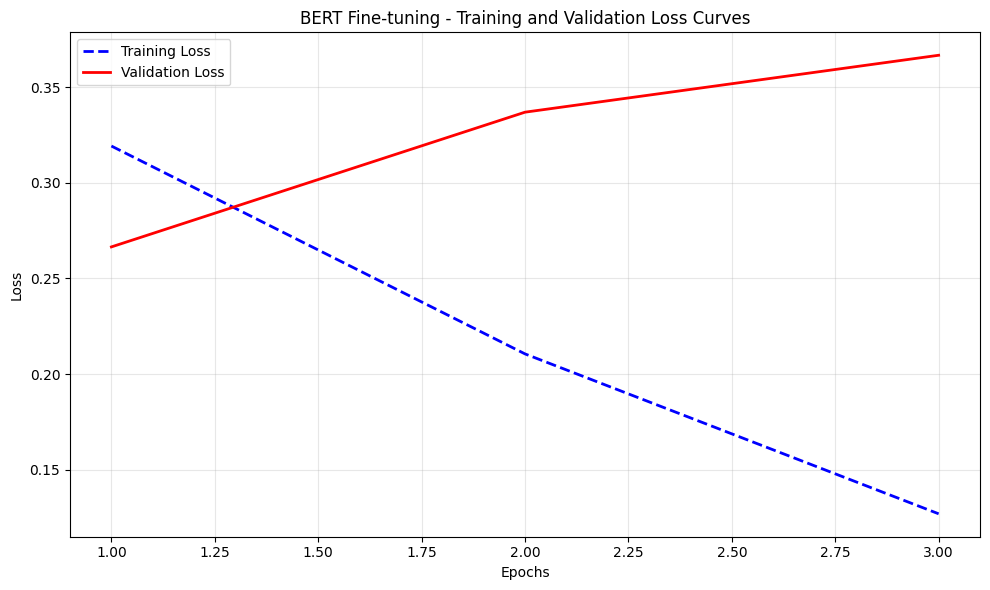


--- BERT Model Evaluation ---


Evaluating: 100%|██████████| 1875/1875 [04:35<00:00,  6.80it/s]


=== BERT MODEL DETAILED METRICS ===
Split     Accuracy    Precision   Recall      F1          
----------------------------------------------------------
Train     0.9476        0.9476        0.9476        0.9476
Val       0.9145        0.9145        0.9145        0.9145
Test      0.9170        0.9170        0.9170        0.9170

=== BERT CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

    negative       0.92      0.92      0.92      7500
    positive       0.92      0.92      0.92      7500

    accuracy                           0.92     15000
   macro avg       0.92      0.92      0.92     15000
weighted avg       0.92      0.92      0.92     15000

BERT fine-tuning experiment finished successfully!
Best BERT configuration: {'num_frozen_layers': 6, 'hidden_dim': 768, 'num_hidden_layers': 1, 'dropout_rate': 0.3, 'learning_rate': 3e-05, 'batch_size': 8}
BERT test accuracy: 0.9170
BERT test F1-score: 0.9170


In [ ]:
# Run BERT experiment
bert_model, bert_test_results, bert_best_config = run_bert_sentiment_analysis(train_data, test_data)

print("BERT fine-tuning experiment finished successfully!")
print(f"Best BERT configuration: {bert_best_config}")
print(f"BERT test accuracy: {bert_test_results['accuracy']:.4f}")
print(f"BERT test F1-score: {bert_test_results['f1']:.4f}")

## Results Comparison

Comparing BERT fine-tuned model against baseline classifier performance.

In [ ]:
print(f"=== TEST SET PERFORMANCE ===")
print(f"{'Model':<20}{'Accuracy':<12}{'F1-Score':<12}{'Improvement':<15}")
print("-" * 59)
print(f"{'Baseline':<20}{baseline_accuracy:.4f}{' '*8}{baseline_f1:.4f}{' '*8}{'---':<15}")
print(f"{'BERT Fine-tuned':<20}{bert_test_results['accuracy']:.4f}{' '*8}{bert_test_results['f1']:.4f}{' '*8}{((bert_test_results['accuracy'] - baseline_accuracy) / baseline_accuracy * 100):+.1f}% accuracy")

=== TEST SET PERFORMANCE ===
Model               Accuracy    F1-Score    Improvement    
-----------------------------------------------------------
Baseline            0.7778        0.7774        ---            
BERT Fine-tuned     0.9170        0.9170        +17.9% accuracy


## Key Findings

- **BERT Performance**: 91.70% test accuracy (+17.9% vs baseline)
- **Optimal Strategy**: 6 frozen BERT layers with 3e-5 learning rate
- **Efficiency**: Partial freezing maintains performance with reduced parameters
- **Technical**: Successfully handled sequence length limitations via truncation

**Conclusion**: Transformer-based approaches significantly outperform traditional methods for sentiment classification tasks.